Práctico 3 - Ramiro Sanes (368397) y Joaquín Guerra (307854)

# Perceptrón de Hinton
### Descripción General del Práctico
En este práctico, exploraremos la implementación y el entrenamiento de un modelo Perceptrón de Hinton para generación de imágenes. Usaremos los datasets [MNIST](https://es.wikipedia.org/wiki/Base_de_datos_MNIST) y [FashionMNIST](https://en.wikipedia.org/wiki/Fashion_MNIST).

### Objetivo del Práctico
El objetivo de este práctico es endender cómo se implementa y entrena el Perceptrón presentado por Hinton para generación de imágenes.

### Imports

In [1]:
import time
import math
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

### Seteo de Device

Seteamos sobre que dispositivo vamos a estar corriendo el entrenamiento e inferencia.

In [2]:
DEVICE = torch.device(
    'cuda:0' if torch.cuda.is_available() else 
    'mps' if torch.backends.mps.is_available() else 
    'cpu'
)
print(DEVICE)

#torch.manual_seed(42)
#torch.backends.cudnn.deterministic = True

cpu


### Transformaciones:

Creamos la transformación para binarizar nuestro dataset. Esto va a hacer que pasemos de $[0, 256]$ a $\{0, 1\}$. A su vez agregamos la transformación trabajar con tensores.

In [172]:
class BinarizedTransform:
    def __call__(self, img):
        return (img > .05).float()
    
    
img_transforms = transforms.Compose([transforms.ToTensor(), BinarizedTransform()])
#img_transforms = transforms.Compose([transforms.ToTensor()])
img_shape = (28,28)
img_size = 28*28*1
num_classes = 10

### Dataset

Vamos a estar trabajando con el dataset de [MNIST](https://es.wikipedia.org/wiki/Base_de_datos_MNIST) que nos brinda imágenes de 28*28 de dígitos escritos a mano.

Para la generación vamos a estar trabajando únicamente con un solo dígito. Vamos a setearlo en este momento y continuamos trabajando con este.

In [4]:
labels_used = [8]

### Carga de datos y creación de Dataloader.

In [166]:
BATCH_SIZE = 64

download_dataset = False # If you already have the dataset you could use False

train_data = datasets.MNIST(root='mnist/', train=True, transform=img_transforms, download=download_dataset)
#train_data = datasets.MNIST(root='mnist/', train=True, transform=img_transforms, download=download_dataset)
train_data = [(image, label) for image, label in train_data if labels_used and label in labels_used]

train_dataloader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)


### Exploración del Dataset

In [156]:
def show_images(images, title="MNIST Images"):
    n = len(images)
    rows = math.floor(math.sqrt(n))
    columns = math.ceil(n / rows)

    fig, axs = plt.subplots(rows, columns)
    fig.suptitle(title, fontsize=14, y=.95)

    for i in range(rows):
        for j in range(columns):
            index = i*columns + j
            if index < n:
                axs[i,j].imshow(images[index], cmap='gray')
            axs[i,j].axis('off')

    plt.show()

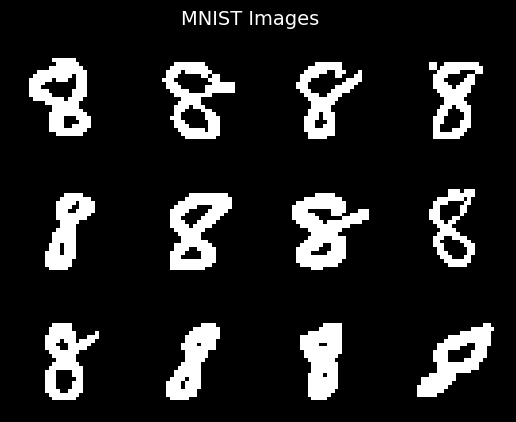

In [157]:
images = []
for _ in range(12):
    image, label = train_data[random.randrange(len(train_data))]
    images.append(image.reshape(img_shape))
show_images(images)

### Definicion de Hinton Perceptron

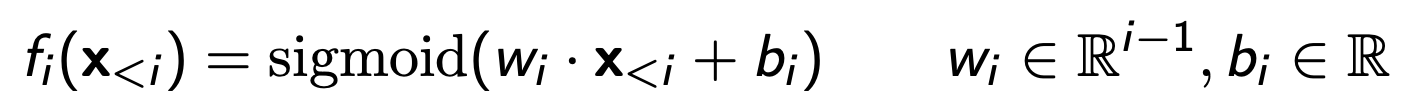

Para replicar esto usaremos una máscara que deje a todos los pesos que "ven el futuro" no afecten la predicción.
Revisar [torch.tril](https://docs.pytorch.org/docs/stable/generated/torch.tril.html). No se olviden de la diagonal!

In [8]:
ones = torch.ones((3,3))

masked_ones = torch.tril(ones, diagonal=-1) # Usar torch.tril para crear una mascara triangular inferior
print(masked_ones.T)
print(torch.matmul(ones, masked_ones.T))

tensor([[0., 1., 1.],
        [0., 0., 1.],
        [0., 0., 0.]])
tensor([[0., 1., 2.],
        [0., 1., 2.],
        [0., 1., 2.]])


¿Qué resultado debería dara la multiplicación de ones . masked_ones.T?

Nos da otra matriz de 3x3 en la que todos los valores de la columna i (entre 0 y 2) tienen el valor i

Recomendamos usar [nn.Parameter](https://docs.pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) para la definición de los pesos y del bias.

In [158]:
class HintonPerceptron(nn.Module):
    def __init__(
        self,
        input_size: int,
        img_shape: tuple[int, int]
    ):
        super(HintonPerceptron, self).__init__()
        self.img_shape = img_shape
        self.img_size = torch.prod(torch.tensor(img_shape)).item()

        # Inicializamos pesos W
        self.w = nn.Parameter(
            torch.randn((input_size, input_size)) * 0.01)

        # Guardamos la máscara
        self.mask = torch.tril(torch.ones((input_size, input_size)), diagonal=-1).to(DEVICE)

        # Inicializamos bias b
        self.bias = nn.Parameter(torch.zeros(input_size))
        
    def forward(
        self,
        x: torch.Tensor
    ):
        # Aplicamos la máscara a w para no usar pesos futuros
        w_masked = self.w * self.mask

        # Multiplicamos x . w^T (w transpuesta)
        x_w = x.matmul(w_masked.T)

        # Sumamos el bias
        logits = x_w + self.bias
        
        # Aplicamos la función de activación y retornamos
        return torch.sigmoid(logits)
    
    def generate_x(
        self,
        num_images: int
    ):
        # Usamos torch.no_grad() porque no necesitamos gradientes para generar imágenes
        with torch.no_grad():
            
            # Inicializamos las imágenes con ceros
            x = torch.zeros((num_images, self.img_size)).to(DEVICE)
            # Generamos imágenes de tamaño num_images x img_size
            # Para cada píxel
            for i in range(self.img_size):
                p = self.forward(x) 
                #x = self.forward(x)
                for j in range(num_images):
                    #print(f"probabilidad: imagen {j}, pixel {i}: ", x[j, i])
                    pixel = torch.bernoulli(p[j, i])  # Muestreamos una distribución Bernoulli
                    #pixel = torch.bernoulli(x[j, i])
                    x[j, i] = pixel
            x = x.reshape((num_images, *self.img_shape))


            return x.cpu()

### Creación del modelo y seteo de Hyper-parámetros
En esta sección del código, se crea el modelo.

Y se eligen arbitrariamente los siguientes hyper-parámetros:
- learning rate (lr)
- cantidad de épocas (epochs)
- optimizador (optim)

In [159]:
lr = 0.01 # Probamos nosotros
epochs = 30 # Probamos nosotros
criterion = nn.BCELoss # función de pérdida, (vamos a usar BCE)

model = HintonPerceptron(
    input_size=img_size,
    img_shape=img_shape
).to(DEVICE)

In [160]:
optim_1 = optim.Adam(model.parameters(), lr=lr)

¿Por qué eligió usar esa función de pérdida?

Usamos Binary Cross-Entropy porque estamos en un problema de clasificación binaria. Esta función compara la probabilidad predicha con la etiqueta real y penaliza más fuerte los errores grandes.
Las salidas de la red corresponden a la probabilidad de que un pixel sea 1, y se comparan contra el valor real del mismo.

### Proceso de entrenamiento del modelo
En esta celda, se define el entrenamiento del modelo utilizando un conjunto de datos de entrenamiento.

El código optimiza los parámetros del modelo minimizando la función de pérdida previamente definida a través de un optimizador.

In [161]:
def train_model(
    model: nn.Module,
    criterion: nn.Module,
    n_epochs: int,
    train_loader: DataLoader,
    optim: torch.optim.Optimizer,
    print_epoch: int = 1
):
    for epoch in tqdm(range(n_epochs)):
        start_time = time.time()
        learning_error = 0
        for img, _ in train_loader:
            # Aplanamos la imagen y la movemos al dispositivo correspondiente
            x = img.reshape((img.shape[0], -1)).to(DEVICE)
    
            # Reseteamos los gradientes
            optim.zero_grad()

            # Hacemos la predicción
            preds = model(x)

            # Calculamos la loss
            loss = criterion()(preds, x)

            # Hacemos backprop
            loss.backward()

            # Optimizamos
            optim.step()

            learning_error += loss.item()

        if epoch%print_epoch == 0:
            imgs = model.generate_x(12).cpu()
            show_images(imgs, f"Generated images on epoch {epoch+1}")
            print(f"Epoch: {epoch+1} - duration {time.time()-start_time}s- error: {learning_error/len(train_loader)}")

    return model

¿Por qué no usamos los valores de `y` que tiene el dataset? ¿No nos afecta esto al calcular la loss?

El objetivo del modelo no es predecir la etiqueta, es decir a que numero corresponde la imágen de entrada, sino que aprende la probabilidad de que cada pixel esté activado. La función de perdida compara la salida de la red contra los valores de los pixeles (0 y 1) y ajusta los parámetros para que la salida se acerque al valor real del mismo.

### Entrenamos el modelo!

  0%|          | 0/30 [00:00<?, ?it/s]

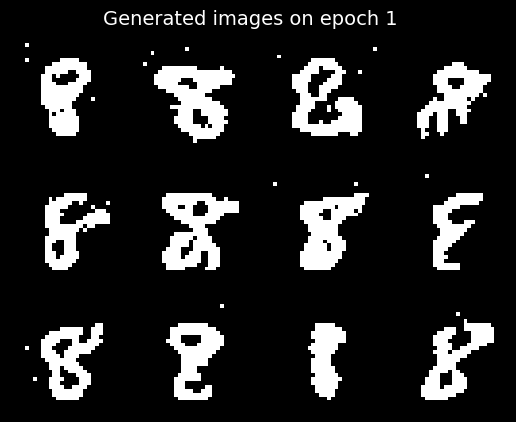

  3%|▎         | 1/30 [00:01<00:48,  1.67s/it]

Epoch: 1 - duration 1.6691298484802246s- error: 0.08828098715647408


  7%|▋         | 2/30 [00:02<00:33,  1.21s/it]

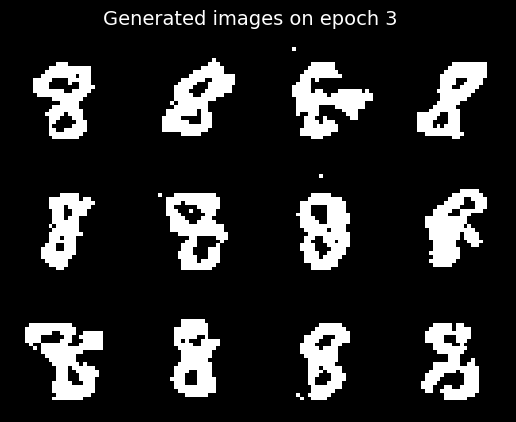

 10%|█         | 3/30 [00:04<00:41,  1.52s/it]

Epoch: 3 - duration 1.8894507884979248s- error: 0.08713131835279257


 13%|█▎        | 4/30 [00:05<00:32,  1.26s/it]

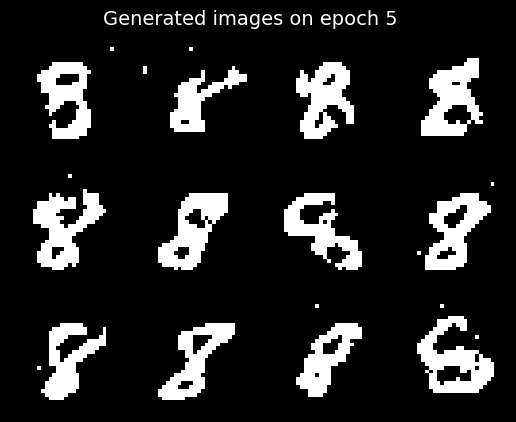

 17%|█▋        | 5/30 [00:07<00:36,  1.46s/it]

Epoch: 5 - duration 1.8242533206939697s- error: 0.08613759376432585


 20%|██        | 6/30 [00:08<00:30,  1.27s/it]

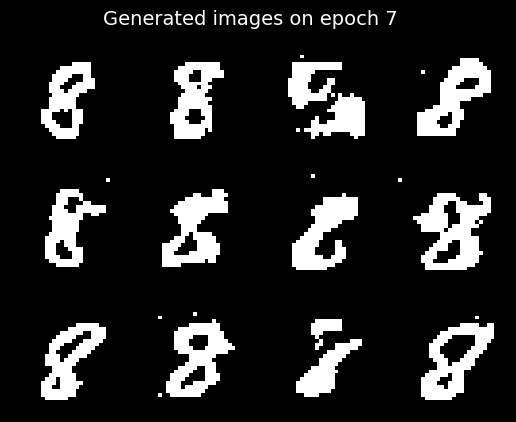

 23%|██▎       | 7/30 [00:10<00:34,  1.52s/it]

Epoch: 7 - duration 2.0265934467315674s- error: 0.08526201594782912


 27%|██▋       | 8/30 [00:10<00:28,  1.31s/it]

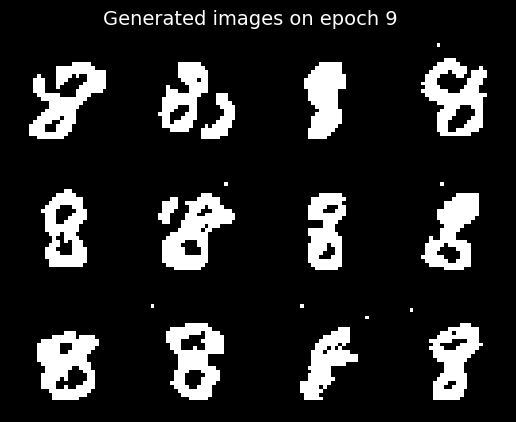

 30%|███       | 9/30 [00:12<00:30,  1.45s/it]

Epoch: 9 - duration 1.7635445594787598s- error: 0.08466244399871516


 33%|███▎      | 10/30 [00:13<00:25,  1.29s/it]

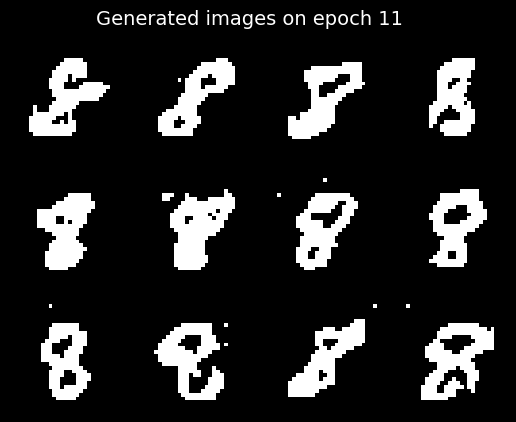

 37%|███▋      | 11/30 [00:15<00:28,  1.50s/it]

Epoch: 11 - duration 1.9737980365753174s- error: 0.08403632579290349


 40%|████      | 12/30 [00:16<00:23,  1.31s/it]

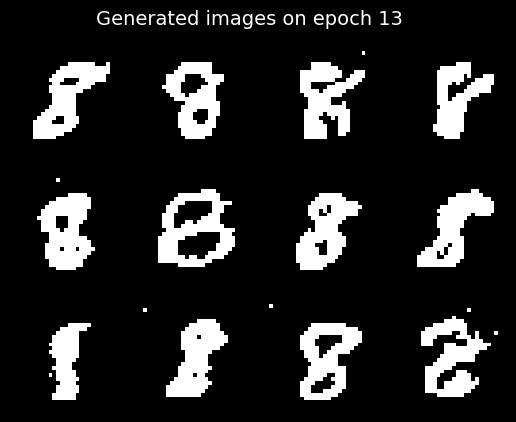

 43%|████▎     | 13/30 [00:18<00:25,  1.48s/it]

Epoch: 13 - duration 1.8556795120239258s- error: 0.08361759935708149


 47%|████▋     | 14/30 [00:19<00:21,  1.32s/it]

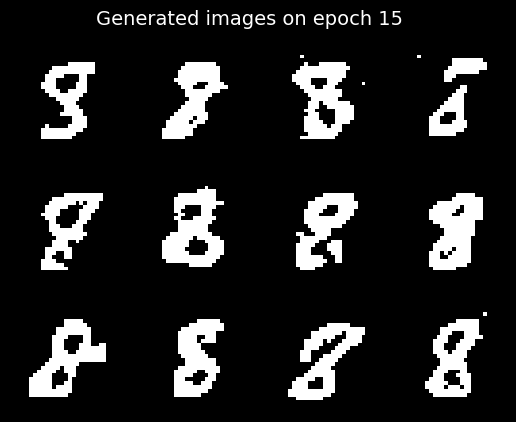

 50%|█████     | 15/30 [00:21<00:21,  1.45s/it]

Epoch: 15 - duration 1.7553117275238037s- error: 0.08315490906977135


 53%|█████▎    | 16/30 [00:21<00:18,  1.29s/it]

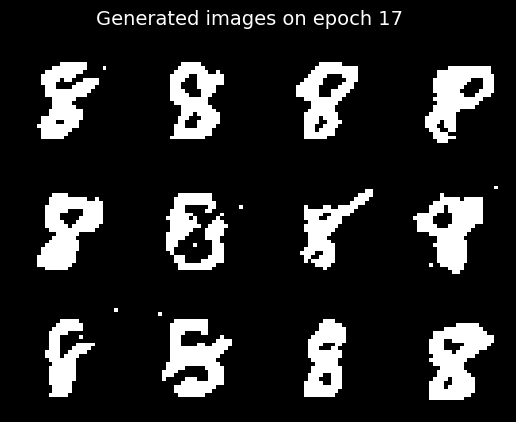

 57%|█████▋    | 17/30 [00:23<00:18,  1.44s/it]

Epoch: 17 - duration 1.7767674922943115s- error: 0.08278354087277599


 60%|██████    | 18/30 [00:24<00:15,  1.32s/it]

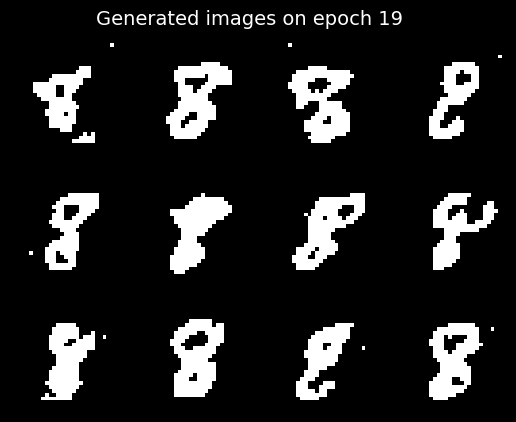

 63%|██████▎   | 19/30 [00:26<00:17,  1.57s/it]

Epoch: 19 - duration 2.16658878326416s- error: 0.08237849831905054


 67%|██████▋   | 20/30 [00:27<00:13,  1.34s/it]

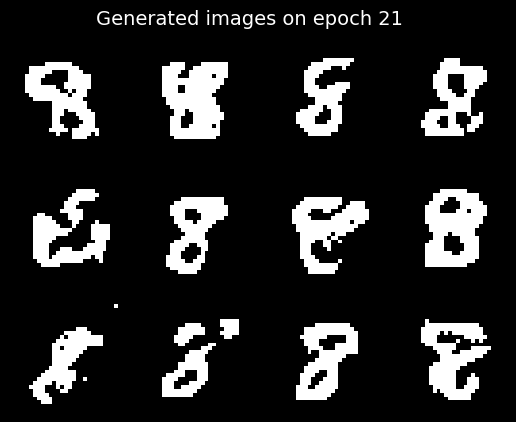

 70%|███████   | 21/30 [00:29<00:13,  1.53s/it]

Epoch: 21 - duration 1.9876482486724854s- error: 0.08209414440004723


 73%|███████▎  | 22/30 [00:30<00:10,  1.35s/it]

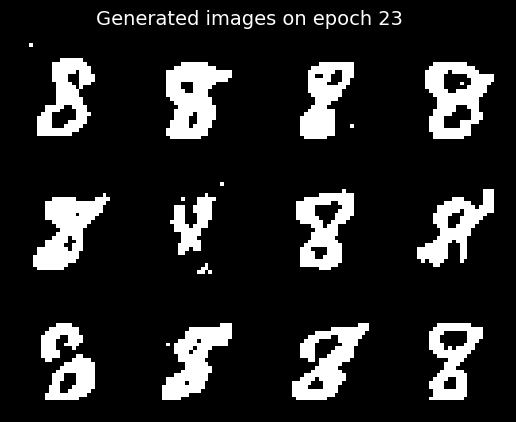

 77%|███████▋  | 23/30 [00:32<00:10,  1.45s/it]

Epoch: 23 - duration 1.6916451454162598s- error: 0.08187654371494832


 80%|████████  | 24/30 [00:33<00:07,  1.27s/it]

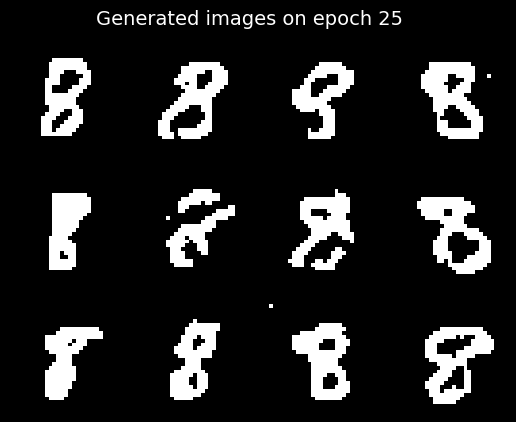

 83%|████████▎ | 25/30 [00:35<00:07,  1.46s/it]

Epoch: 25 - duration 1.8917691707611084s- error: 0.08174028660616149


 87%|████████▋ | 26/30 [00:35<00:05,  1.28s/it]

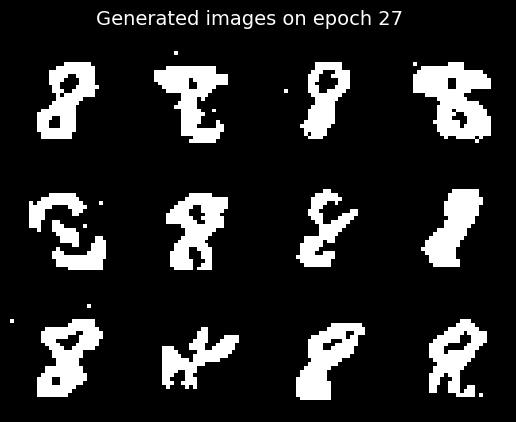

 90%|█████████ | 27/30 [00:37<00:04,  1.39s/it]

Epoch: 27 - duration 1.656550407409668s- error: 0.08140804003114285


 93%|█████████▎| 28/30 [00:38<00:02,  1.23s/it]

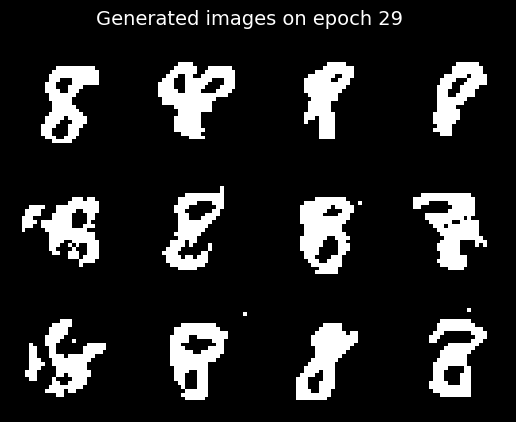

 97%|█████████▋| 29/30 [00:40<00:01,  1.41s/it]

Epoch: 29 - duration 1.8323369026184082s- error: 0.08127743856090566


100%|██████████| 30/30 [00:41<00:00,  1.37s/it]


In [163]:
trained_model = train_model(
    model=model,
    criterion=criterion,
    n_epochs=int(epochs),
    train_loader=train_dataloader,
    optim=optim_1,
    print_epoch=2
)

### Probamos el modelo generando imagenes

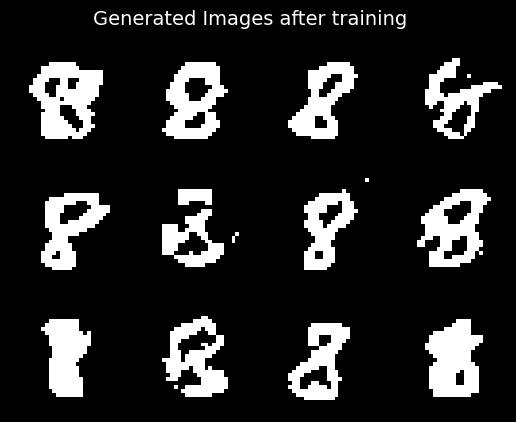

In [164]:
imgs = model.generate_x(12).cpu()
show_images(imgs, "Generated Images after training")

## Ejercicios:
1) Complete el código del perceptrón de Hinton.
2) Entrene el modelo utilizando 1 dígito.
3) Entrene el modelo utilizando al menos 3 dígitos.
4) Compare resultados. ¿Qué diferencias observas?
5) Entrene el modelo con el dataset de [FashionMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).
6) Compare y comente sobre los resultados obtenidos.

## Entrenamiento del modelo utilizando más dígitos

In [167]:
labels_2 = [3,6,9]

In [173]:
train_data_2 = datasets.MNIST(root='mnist/', train=True, transform=img_transforms, download=download_dataset)
train_data_2 = [(image, label) for image, label in train_data_2 if labels_2 and label in labels_2]

train_dataloader_2 = DataLoader(
    train_data_2, batch_size=BATCH_SIZE, shuffle=True
)


In [169]:
model_2 = HintonPerceptron(
    input_size=img_size,
    img_shape=img_shape
).to(DEVICE)

In [170]:
optim_2 = optim.Adam(model_2.parameters(), lr=0.01)

  0%|          | 0/30 [00:00<?, ?it/s]

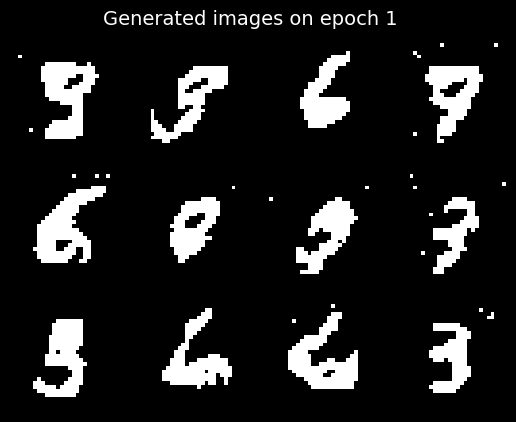

  3%|▎         | 1/30 [00:03<01:34,  3.28s/it]

Epoch: 1 - duration 3.2758231163024902s- error: 0.08818081969804797


  7%|▋         | 2/30 [00:06<01:23,  2.97s/it]

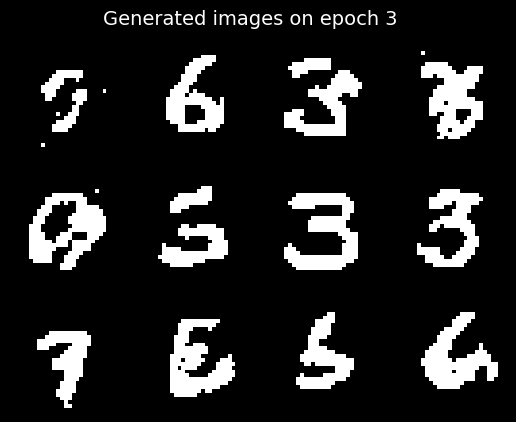

 10%|█         | 3/30 [00:09<01:26,  3.22s/it]

Epoch: 3 - duration 3.5078301429748535s- error: 0.08579672817537125


 13%|█▎        | 4/30 [00:12<01:17,  2.97s/it]

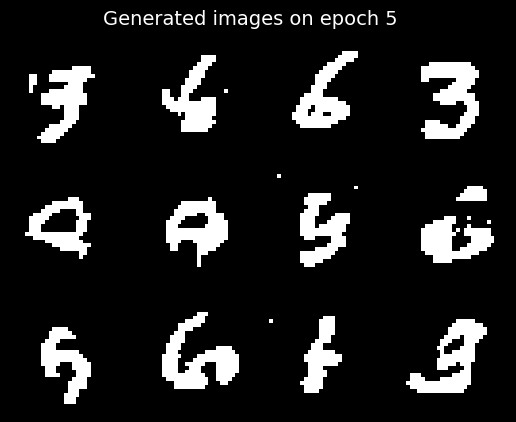

 17%|█▋        | 5/30 [00:15<01:19,  3.18s/it]

Epoch: 5 - duration 3.5474302768707275s- error: 0.08442427669750883


 20%|██        | 6/30 [00:18<01:11,  2.97s/it]

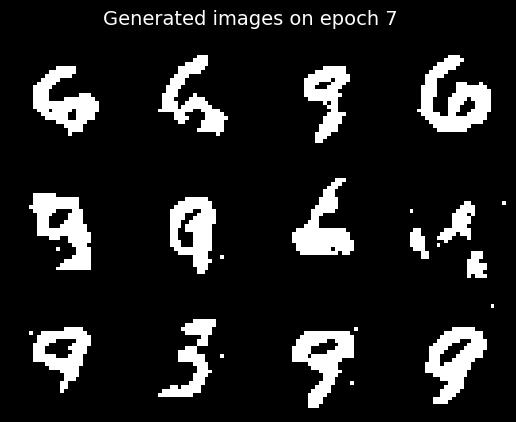

 23%|██▎       | 7/30 [00:21<01:11,  3.13s/it]

Epoch: 7 - duration 3.4425406455993652s- error: 0.08357685455616484


 27%|██▋       | 8/30 [00:24<01:04,  2.95s/it]

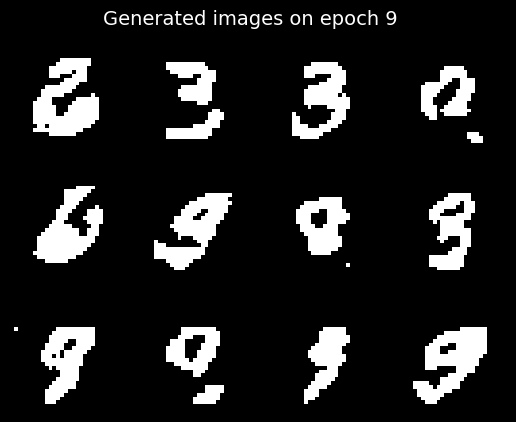

 30%|███       | 9/30 [00:27<01:06,  3.15s/it]

Epoch: 9 - duration 3.584230422973633s- error: 0.08301189446702917


 33%|███▎      | 10/30 [00:30<00:58,  2.95s/it]

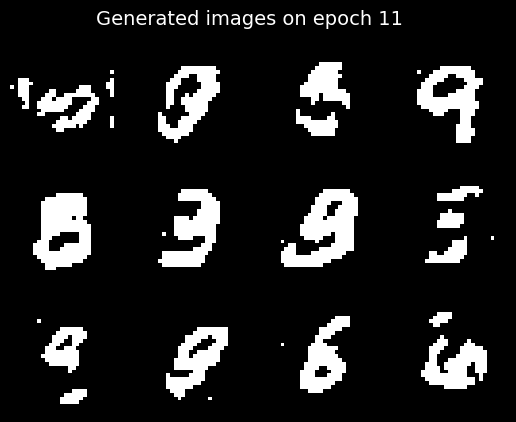

 37%|███▋      | 11/30 [00:34<01:00,  3.20s/it]

Epoch: 11 - duration 3.7800276279449463s- error: 0.08255617291475019


 40%|████      | 12/30 [00:36<00:54,  3.04s/it]

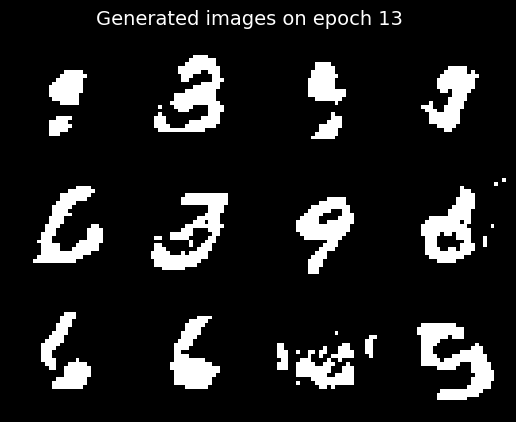

 43%|████▎     | 13/30 [00:40<00:55,  3.24s/it]

Epoch: 13 - duration 3.720837116241455s- error: 0.08223964464157185


 47%|████▋     | 14/30 [00:43<00:49,  3.06s/it]

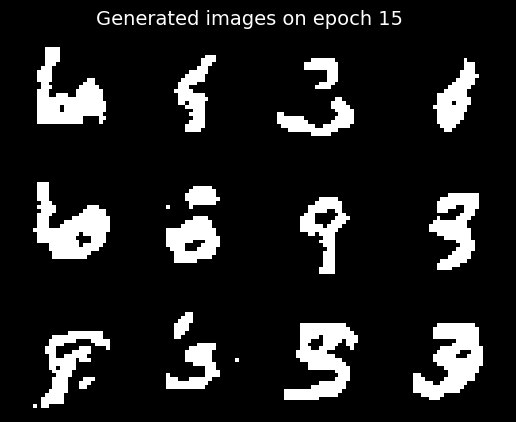

 50%|█████     | 15/30 [00:47<00:49,  3.32s/it]

Epoch: 15 - duration 3.9072813987731934s- error: 0.08195399981758274


 53%|█████▎    | 16/30 [00:49<00:44,  3.19s/it]

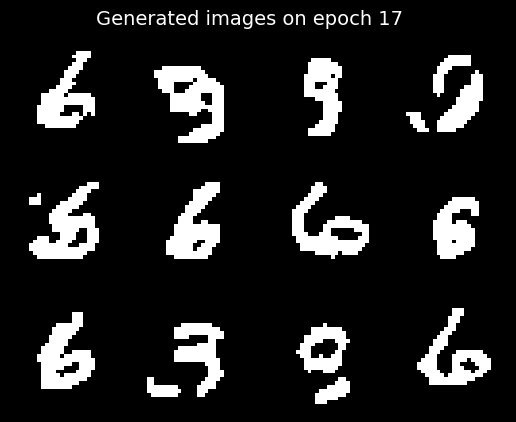

 57%|█████▋    | 17/30 [00:53<00:43,  3.36s/it]

Epoch: 17 - duration 3.7741892337799072s- error: 0.08174427770448069


 60%|██████    | 18/30 [00:56<00:37,  3.15s/it]

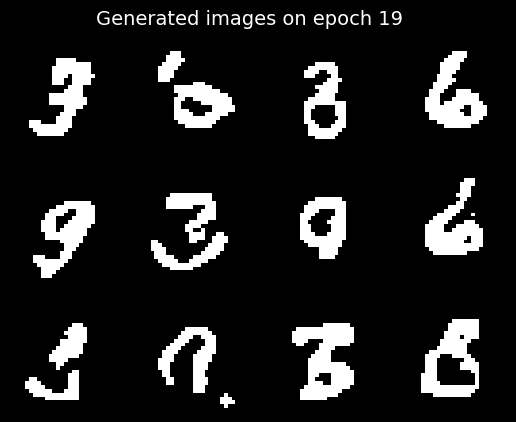

 63%|██████▎   | 19/30 [01:00<00:36,  3.29s/it]

Epoch: 19 - duration 3.620771884918213s- error: 0.08157486745968778


 67%|██████▋   | 20/30 [01:02<00:31,  3.11s/it]

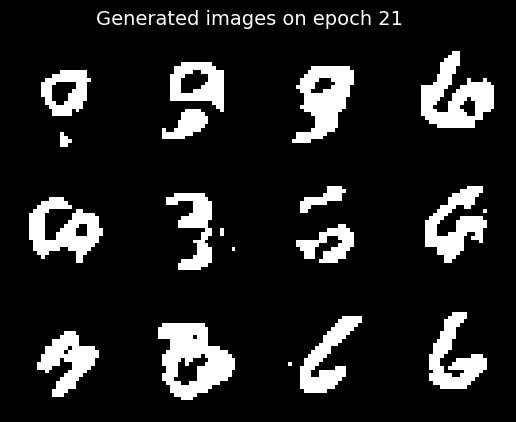

 70%|███████   | 21/30 [01:06<00:29,  3.25s/it]

Epoch: 21 - duration 3.5645196437835693s- error: 0.08147201943376385


 73%|███████▎  | 22/30 [01:08<00:24,  3.09s/it]

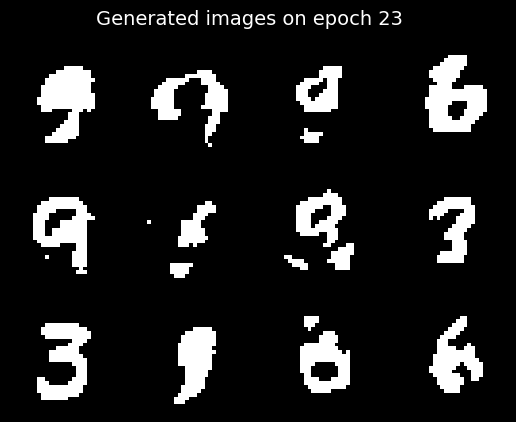

 77%|███████▋  | 23/30 [01:12<00:22,  3.24s/it]

Epoch: 23 - duration 3.59869122505188s- error: 0.08135561880173413


 80%|████████  | 24/30 [01:15<00:18,  3.13s/it]

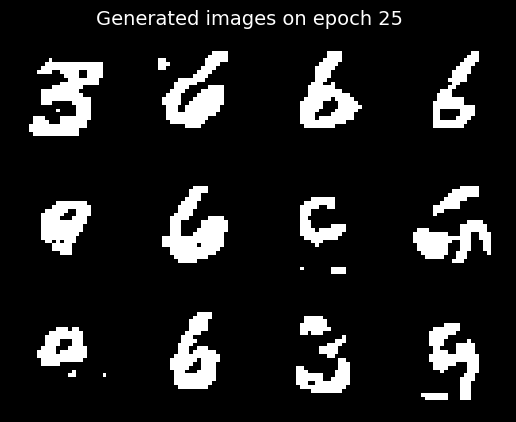

 83%|████████▎ | 25/30 [01:19<00:16,  3.36s/it]

Epoch: 25 - duration 3.8838517665863037s- error: 0.08128699348539326


 87%|████████▋ | 26/30 [01:21<00:12,  3.14s/it]

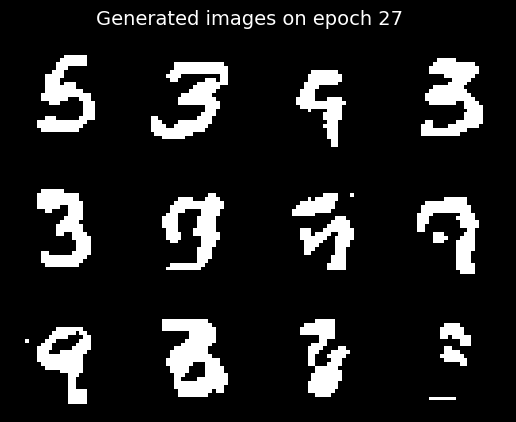

 90%|█████████ | 27/30 [01:25<00:09,  3.24s/it]

Epoch: 27 - duration 3.4637653827667236s- error: 0.08114038000926904


 93%|█████████▎| 28/30 [01:28<00:06,  3.04s/it]

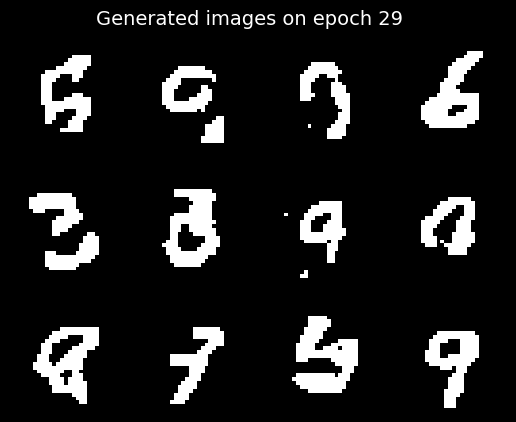

 97%|█████████▋| 29/30 [01:31<00:03,  3.17s/it]

Epoch: 29 - duration 3.474475860595703s- error: 0.08107554423787915


100%|██████████| 30/30 [01:34<00:00,  3.14s/it]


In [174]:
trained_model = train_model(
    model=model_2,
    criterion=criterion,
    n_epochs=int(epochs),
    train_loader=train_dataloader_2,
    optim=optim_2,
    print_epoch=2
)

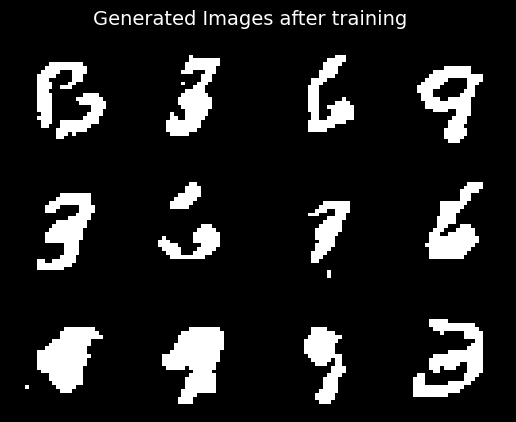

In [175]:
imgs = model_2.generate_x(12).cpu()
show_images(imgs, "Generated Images after training")

Observamos que al entrenar el modelo con 3 etiquetas distintas, las imágenes que genera luego son más confusas que las generadas al ser entrenado únicamente con 1 etiqueta. Esto ocurre debido a que la distribución de los datos con los que entrena este nuevo modelo es bastante mas compleja al ser multimodal, por lo que es más dificil de aprender con una red de igual complejidad.

## FashionMNIST

Utilizamos el label 7 (Sneakers) para entrenar al modelo

In [144]:
label_fmnist = [7]

In [176]:
img_transforms_2 = transforms.Compose([transforms.ToTensor(), BinarizedTransform()])

In [177]:
download_dataset = False # If you already have the dataset you could use False

train_data_fmnist = datasets.FashionMNIST(root='fashion_mnist/', train=True, transform=img_transforms_2, download=download_dataset)
train_data_fmnist = [(image, label) for image, label in train_data_fmnist if label_fmnist and label in label_fmnist]

train_dataloader_fmnist = DataLoader(
    train_data_fmnist, batch_size=BATCH_SIZE, shuffle=True
)


In [178]:
train_data_fmnist_test = datasets.FashionMNIST(root='fashion_mnist/', train=True, transform=img_transforms_2, download=download_dataset)

In [179]:
train_data_fmnist_test.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

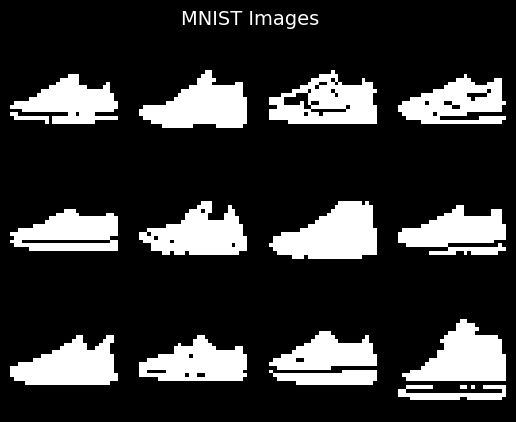

In [180]:
images = []
for i in range(12):
    image, label = train_data_fmnist[random.randrange(len(train_data_fmnist))]
    #image, label = train_data_fmnist[i]
    #print(image)
    images.append(image.reshape(img_shape))
show_images(images)

In [151]:
model_fmnist = HintonPerceptron(
    input_size=img_size,
    img_shape=img_shape
).to(DEVICE)

In [152]:
optim_3 = optim.Adam(model_fmnist.parameters(), lr=0.01)

  0%|          | 0/30 [00:00<?, ?it/s]

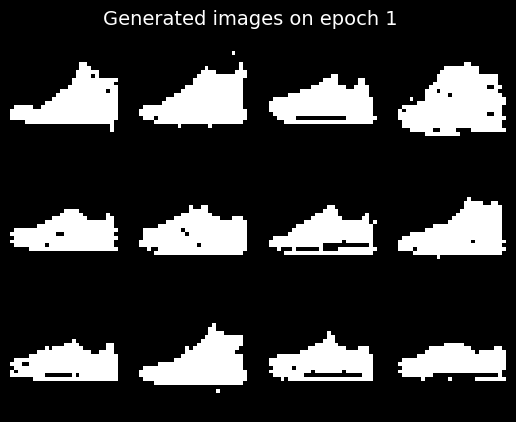

  3%|▎         | 1/30 [00:30<14:50, 30.71s/it]

Epoch: 1 - duration 30.708975791931152s- error: 0.7753449730612337


  7%|▋         | 2/30 [01:02<14:36, 31.31s/it]

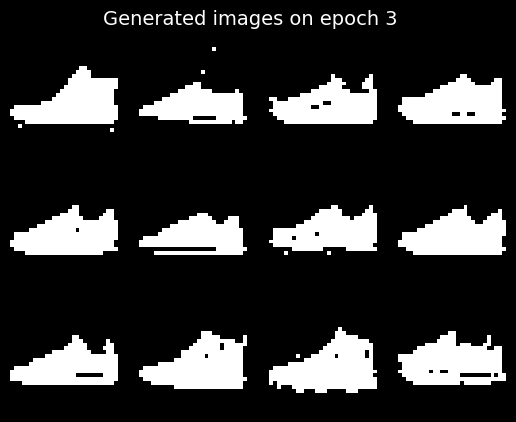

 10%|█         | 3/30 [01:36<14:44, 32.78s/it]

Epoch: 3 - duration 34.51896333694458s- error: 0.6137285078726709


 13%|█▎        | 4/30 [02:15<15:10, 35.01s/it]

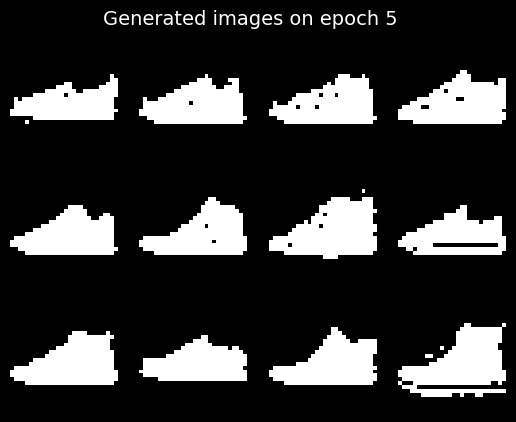

 17%|█▋        | 5/30 [02:55<15:24, 36.99s/it]

Epoch: 5 - duration 40.51122331619263s- error: 0.5724021348798026


 20%|██        | 6/30 [03:34<14:58, 37.43s/it]

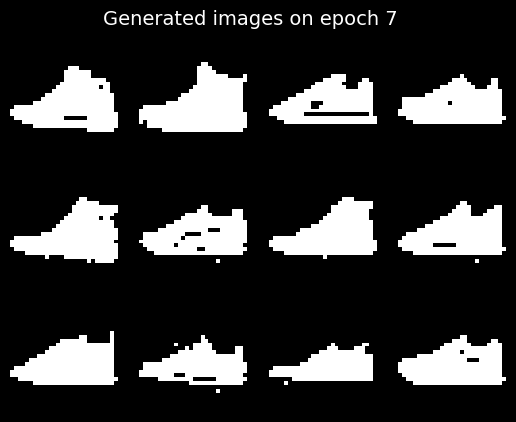

 23%|██▎       | 7/30 [04:11<14:17, 37.29s/it]

Epoch: 7 - duration 36.994160413742065s- error: 0.5726826373167957


 27%|██▋       | 8/30 [04:50<13:54, 37.94s/it]

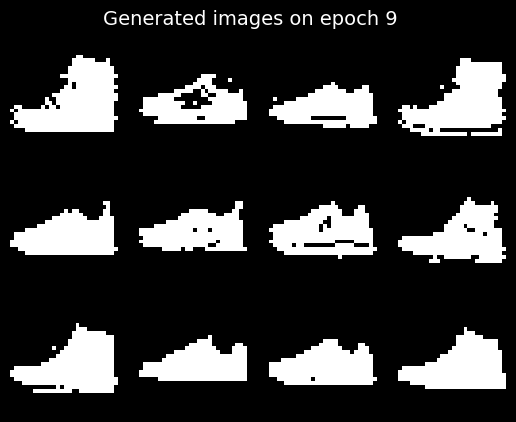

 30%|███       | 9/30 [05:25<12:57, 37.02s/it]

Epoch: 9 - duration 34.982646226882935s- error: 0.5493031513042127


 33%|███▎      | 10/30 [05:59<12:02, 36.11s/it]

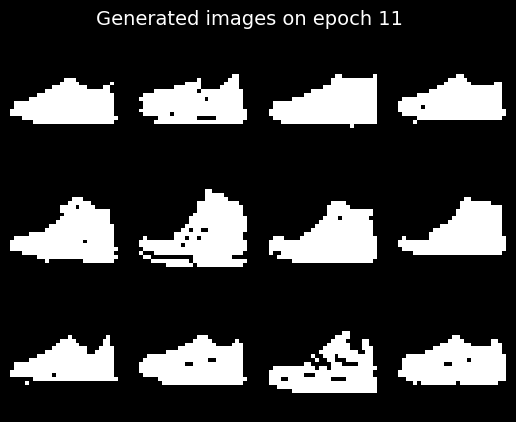

 37%|███▋      | 11/30 [06:34<11:21, 35.87s/it]

Epoch: 11 - duration 35.334667921066284s- error: 0.5250968148357545


 40%|████      | 12/30 [07:13<11:03, 36.85s/it]

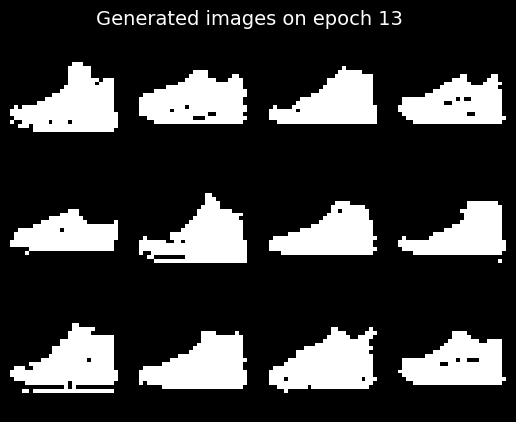

 43%|████▎     | 13/30 [07:58<11:05, 39.17s/it]

Epoch: 13 - duration 44.50774145126343s- error: 0.5261020612691839


 47%|████▋     | 14/30 [08:41<10:43, 40.25s/it]

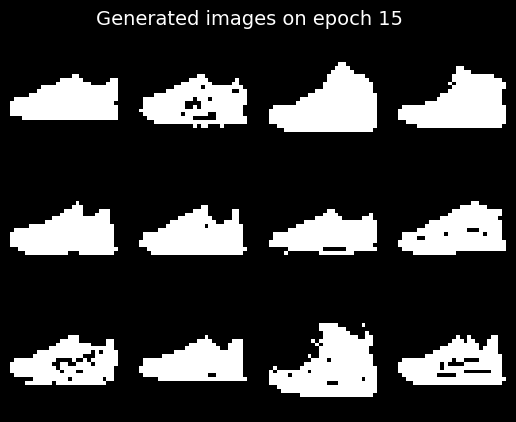

 50%|█████     | 15/30 [09:26<10:24, 41.62s/it]

Epoch: 15 - duration 44.7866644859314s- error: 0.5259020727208505


 53%|█████▎    | 16/30 [10:06<09:36, 41.21s/it]

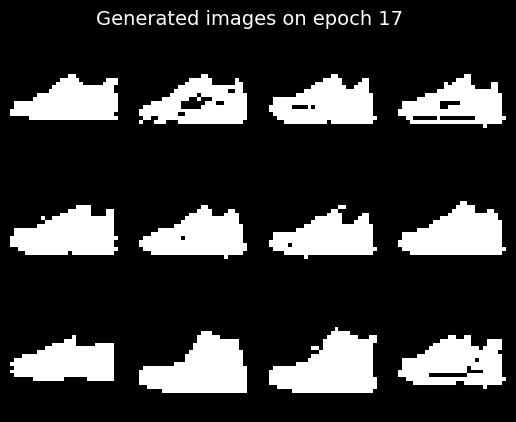

 57%|█████▋    | 17/30 [10:43<08:38, 39.92s/it]

Epoch: 17 - duration 36.90724325180054s- error: 0.526793268394346


 60%|██████    | 18/30 [11:19<07:44, 38.72s/it]

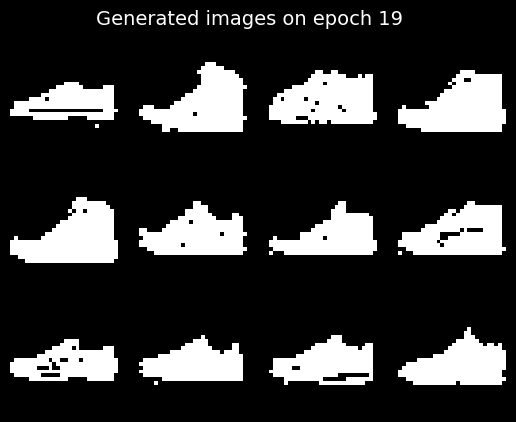

 63%|██████▎   | 19/30 [11:56<07:00, 38.19s/it]

Epoch: 19 - duration 36.936543703079224s- error: 0.5266891912606855


 67%|██████▋   | 20/30 [12:32<06:16, 37.60s/it]

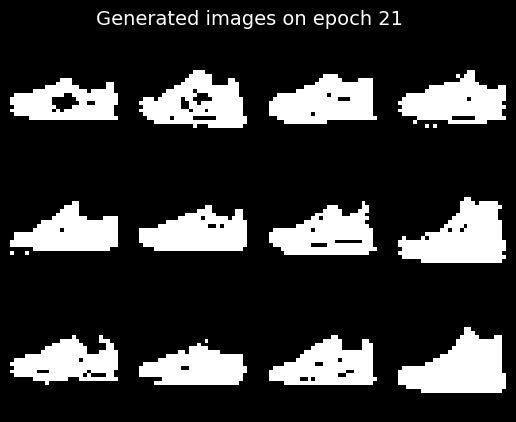

 70%|███████   | 21/30 [13:11<05:41, 37.97s/it]

Epoch: 21 - duration 38.81694149971008s- error: 0.527018506540296


 73%|███████▎  | 22/30 [13:47<05:00, 37.53s/it]

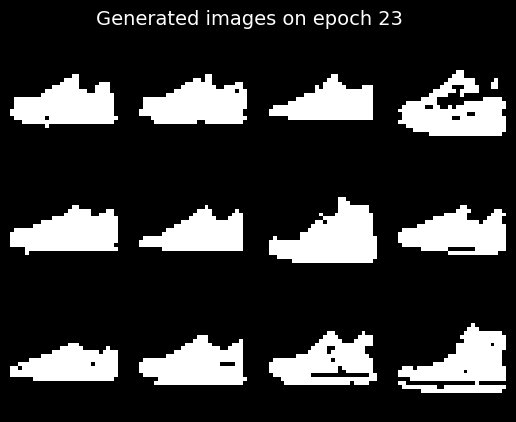

 77%|███████▋  | 23/30 [14:24<04:22, 37.45s/it]

Epoch: 23 - duration 37.241703271865845s- error: 0.5282533761980012


 80%|████████  | 24/30 [15:09<03:57, 39.53s/it]

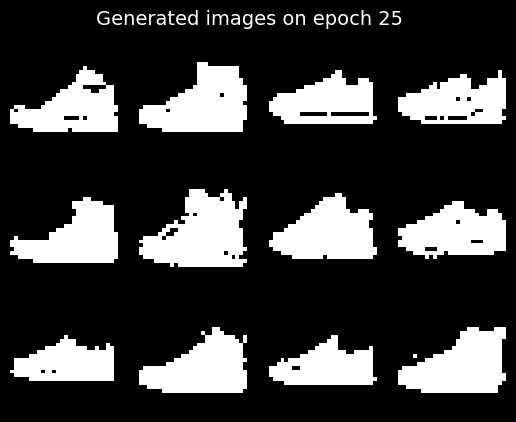

 83%|████████▎ | 25/30 [15:54<03:26, 41.27s/it]

Epoch: 25 - duration 45.333844900131226s- error: 0.5287284173211083


 87%|████████▋ | 26/30 [16:39<02:49, 42.40s/it]

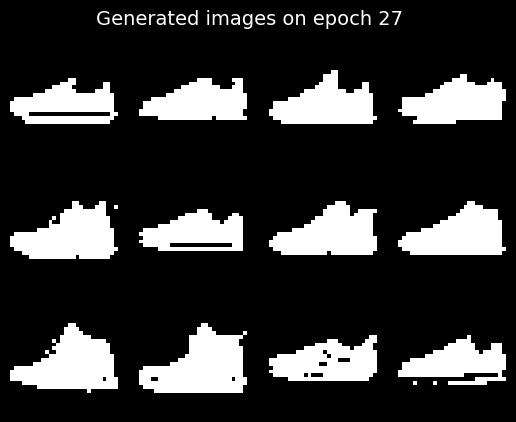

 90%|█████████ | 27/30 [17:33<02:17, 45.75s/it]

Epoch: 27 - duration 53.576478004455566s- error: 0.5291429102560505


 93%|█████████▎| 28/30 [18:19<01:31, 45.97s/it]

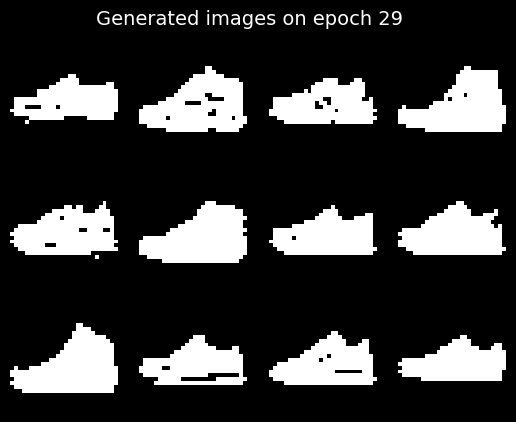

 97%|█████████▋| 29/30 [19:08<00:46, 46.68s/it]

Epoch: 29 - duration 48.33317160606384s- error: 0.5300629961599286


100%|██████████| 30/30 [19:55<00:00, 39.86s/it]


In [154]:
trained_model = train_model(
    model=model_fmnist,
    criterion=criterion,
    n_epochs=int(epochs),
    train_loader=train_data_fmnist,
    optim=optim_3,
    print_epoch=2
)

Entrenamos el mismo modelo con el dataset FashionMNIST, aplicando las mismas transformaciones. Al entrenar durante 30 epocas observamos que las imágenes generadas por el modelo se corresponden bastante a la distribución con la que lo entrenamos (Sneakers).
Se observa también que a partir de la epoca 15, el error del entrenamiento deja de disminuir.